In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lcode2dPy.diagnostics.openpmd import Diagnostics
from lcode2dPy.diagnostics.openpmd import FieldsDiagnostics, PlasmaDiagnostics, BeamDiagnostics
from lcode2dPy.simulation.interface import Simulation
from lcode2dPy.config.default_config import default_config
from lcode2dPy.beam.beam_generator import make_beam, Gauss, rGauss

In [3]:
# Параметры
# time_step       = 200
# time_limit      = 200.5
# window_length   = 15
# window_width    = 5
# r_step          = 0.05
# xi_step         = 0.05
time_step       = 500
time_limit      = 1000
window_length   = 15
window_width    = 4
r_step          = 0.05
xi_step         = 0.05

In [4]:
!rm ../c_code/*
config = default_config
config.set('time-step', time_step)
config.set('time-limit', time_limit)
config.set('window-length', window_length)
config.set('window-width', window_width)
config.set('window-width-step-size', r_step)
config.set('xi-step', xi_step)

gamma = 426
angspread = 1e-5
m_proton = 958/0.51

beam_pars = dict(xi_distr=Gauss(sigma=100, vmin=-window_length, vmax=0),
                r_distr=rGauss(vmin=0, vmax=window_width),
                ang_distr=Gauss(sigma=angspread, vmin=None, vmax=None),
                pz_distr=Gauss(gamma*m_proton, gamma*m_proton*1e-4, vmin=None, vmax=None),
                Ipeak_kA=2*40/1000,
                q_m=1/m_proton,
                saveto="../c_code")

diagnostics = Diagnostics( 
    path = "./diagnostics/", 
    author = "Nikita Okhotnikov <nikiquark@gmail.com>", 
    content = [
        #FieldsDiagnostics(config, period=200, time=(None,None), select={"E_z": -1}),
        #PlasmaDiagnostics(config, period=200, time=(None,None)),
        BeamDiagnostics(config, period=200, time=(None, None))
    ]
)

sim = Simulation(beam_pars=beam_pars, diagnostics=diagnostics, config=config)

sim.step(int(time_limit//time_step))

Number of particles: 119551
Number of particles in the middle layer: 200
0.0
500.0


In [5]:
import openpmd_api as io
series = io.Series(
    "diagnostics/000000_000.h5",
    io.Access.read_only)
i = series.iterations[0]


In [19]:
E = i.meshes["E"]
Ez = E["z"]
Ez_data = Ez.load_chunk()
series.flush()

In [6]:
bp = i.particles["beam_particles"]
beam_xi_raw = bp["position"]["xi"]
beam_r_raw  = bp["position"]["r"]
beam_xi = beam_xi_raw.load_chunk()
beam_r = beam_r_raw.load_chunk()
series.flush()
del series

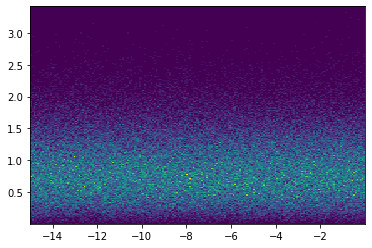

In [7]:
plt.hist2d(beam_xi, beam_r, bins=200);